In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np  
import scipy
from scipy.stats import norm
from scipy.stats import pearsonr
from scipy.optimize import minimize
import math
from scipy.optimize import Bounds
from scipy.stats import poisson
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import pacf
import matplotlib.dates as mdates
# import mpl_scatter_density # adds projection='scatter_density'


Load data

In [2]:
data_dir = os.path.join("data", "EnergyUsageClassroomsAll.csv")
energy_data = pd.read_csv(data_dir)
energy_data[['Time','Zone']]= energy_data['ts'].str.split(' ', n=1, expand=True)
energy_data = energy_data.set_index('Time')
energy_data.index = pd.to_datetime(energy_data.index, format='mixed')

C:\Users\fenya\AppData\Local\Temp\ipykernel_8868\1209776220.py:5: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  energy_data.index = pd.to_datetime(energy_data.index, format='mixed')


In [3]:
data_dir = os.path.join("data", "WeatherHistorical.csv")
weather_data = pd.read_csv(data_dir)
weather_data[['Time','Zone']]= weather_data['Timestamp'].str.split(' ', n=1, expand=True)
weather_data = weather_data.set_index('Time')
weather_data.index = pd.to_datetime(weather_data.index, format='mixed')

col = 'Ithaca, NY, United States Humidity'
weather_data[col] = (weather_data[col] - weather_data[col].mean())/weather_data[col].std()

col = 'Ithaca, NY, United States Temp'
weather_data[col] = (weather_data[col] - weather_data[col].mean())/weather_data[col].std()

C:\Users\fenya\AppData\Local\Temp\ipykernel_8868\4084514803.py:5: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  weather_data.index = pd.to_datetime(weather_data.index, format='mixed')


In [4]:
weather_data = weather_data.drop(weather_data.index.difference(energy_data.index))
energy_data = energy_data.drop(energy_data.index.difference(weather_data.index))

In [5]:
energy_data = energy_data.drop(['ts','Zone'], axis=1)


In [6]:
data_dir = os.path.join("data", "Cornell_Classroom_Building_Square_Footage.xlsx - Sheet1.csv")
square_footage = pd.read_csv(data_dir)
square_footage['Building Name'] = square_footage['Building Name'].replace(" ", "")
square_footage['Building Name'] = [square_footage['Building Name'][i].replace(" ", "") for i in range(square_footage.shape[0])]
square_footage.index = square_footage['Building Name']

In [7]:
for bdg in energy_data.columns:
    energy_data[bdg] = energy_data[bdg]/float(square_footage.loc[bdg, 'Square Footage (sq ft)'])

In [8]:
energy_data

,GatesHall,WarrenHall,CaldwellHall,LincolnHall,UrisHall,MarthaVanRensselaerWest,IvesHall,StimsonHall,MarthaVanRensselaerComplex,KimballHall,...,GoldwinSmithHall,PlantScience,KlarmanHall,MorrillHall,BaileyHall,RandHall,MyronTaylorHall,SageHall,MilsteinHall,MarthaVanRensselaerHall
Time,,,,,,,,,,,,,,,,,,,,,
2023-12-31 23:00:00-05:00,NaN,NaN,NaN,NaN,0.002093,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.002890,NaN,NaN,0.000539
2024-01-01 00:00:00-05:00,0.002130,0.000478,0.000102,0.000932,0.002112,0.000182,0.001693,0.000068,0.000456,0.015303,...,0.001269,0.001503,0.000362,0.000644,0.000368,0.000098,0.002852,0.000712,0.001472,0.000532
2024-01-01 01:00:00-05:00,0.002119,0.000482,0.000102,0.000886,0.002104,0.000182,0.001915,0.000068,0.000453,0.015868,...,0.001218,0.001458,0.000484,0.000583,0.000381,0.000106,0.002874,0.000723,0.001449,0.000537
2024-01-01 02:00:00-05:00,0.002169,0.000484,0.000108,0.000901,0.002081,0.000204,0.001715,0.000068,0.000466,0.015538,...,0.001274,0.001494,0.000425,0.000446,0.000346,0.000110,0.002932,0.000726,0.001481,0.000541
2024-01-01 03:00:00-05:00,0.002159,0.000487,0.000141,0.000886,0.002118,0.000180,0.001747,0.000068,0.000462,0.015553,...,0.001257,0.001476,0.000403,0.000428,0.000378,0.000113,0.002798,0.000715,0.001490,0.000535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-30 19:00:00-05:00,0.002331,0.000679,0.000094,0.000920,0.001846,0.000149,0.001615,0.000084,0.000587,0.017928,...,0.001233,0.002310,0.000662,0.000673,0.000340,0.000180,0.002863,0.000752,0.001665,0.000690
2024-12-30 20:00:00-05:00,0.002304,0.000691,0.000099,0.000944,0.001832,0.000146,0.001669,0.000092,0.000463,0.017384,...,0.001277,0.001711,0.000486,0.000672,0.000385,0.000147,0.002789,0.000745,0.001623,0.000603
2024-12-30 21:00:00-05:00,0.002251,0.000697,0.000093,0.000915,0.001809,0.000142,0.001592,0.000081,0.000455,0.016596,...,0.001211,0.001652,0.000622,0.000528,0.000327,0.000110,0.002687,0.000751,0.001559,0.000583


In [9]:
np.isnan(weather_data['Ithaca, NY, United States Humidity']).any()

np.False_

In [10]:
y = energy_data.to_numpy().reshape(-1, 1)
nan_data = (np.isnan(y))
y =y[~nan_data].reshape(-1, 1)  

humid = np.repeat(weather_data.iloc[:,[2]], energy_data.shape[1]).reshape(-1, 1)[~nan_data].reshape(-1, 1)  
temp = np.repeat(weather_data.iloc[:,[4]], energy_data.shape[1]).reshape(-1, 1)[~nan_data].reshape(-1, 1)  
# sites = np.tile(df.columns, df.shape[0])

# x_lat =x_lat.reshape(-1, 1)[~nan_data].reshape(-1, 1)
# x_lon =x_lon.reshape(-1, 1)[~nan_data].reshape(-1, 1)

In [11]:
# dates = energy_data.index
dates = np.repeat(energy_data.index, energy_data.shape[1])
months = np.zeros(len(dates))
hours = np.zeros(len(dates))
# len(dates)
# Store months for stratification 
for i in range(dates.shape[0]):
    ts = pd.Timestamp(dates[i])
    months[i]=ts.month

hours = np.zeros(dates.shape[0])
for i in range(dates.shape[0]):
    ts = pd.Timestamp(dates[i])
    hours[i]=ts.hour


months = months.reshape(-1, 1)[~nan_data].reshape(-1, 1)  
hours = hours.reshape(-1, 1)[~nan_data].reshape(-1, 1)  

In [12]:
X = np.concatenate((humid, temp), axis=1)

<Axes: >

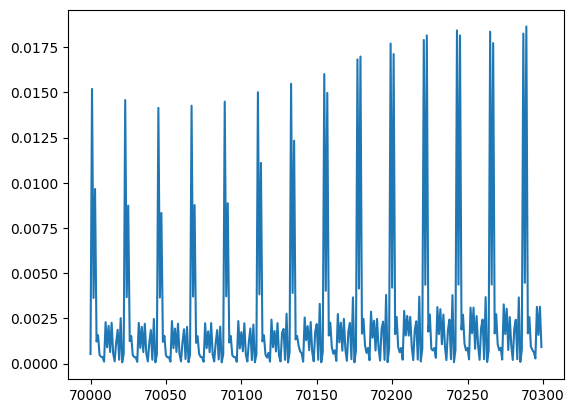

In [13]:
pd.Series(y.reshape(-1,))[70000:70300].plot()

In [14]:
def electricity_linear_model(params, X):
    μ =  params[0] + X[:,0]* params[1] + X[:,1]* params[2] + params[3]*np.cos(params[4]*hours + params[5]) + params[6]*np.cos(params[7]*months + params[8])
    return μ

In [15]:
def electricity_demand_model(params, X, y):
    σ = params[-1]
    μ = electricity_linear_model(params, X)
    ll = np.sum(norm.logpdf(pd.Series(y.reshape(-1,)), μ, scale=σ))  # compute log-likelihood
    return ll

In [16]:
lb = [-10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0, -10000.0]
ub = [10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0]
init = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.01, 0.5, 0.5, 0.5]

result = minimize(lambda θ: -electricity_demand_model(θ, X, y), init, bounds=list(zip(lb, ub)))
θ_mle = result.x

MemoryError: Unable to allocate 272. GiB for an array with shape (190906, 190906) and data type float64

In [ ]:
pd.DataFrame(θ_mle).to_csv('params_classrooms_2022_2024_hour_month_noAR1.csv')

With AR(1) residuals

In [17]:
def electricity_linear_model(params, X):
    μ =  params[0] + X[:,0]* params[1] + X[:,1]* params[2] + params[3]*np.cos(params[4]*hours + params[5]) + params[6]*np.cos(params[7]*months + params[8])
    return μ

In [18]:
def elec_loglik(params, X, y):
    ρ = params[-1]
    σ = params[-2]
    elec_sim = electricity_linear_model(params, X)
    residuals = (y - np.array(elec_sim).reshape(-1,1))
    # ll = np.sum(norm.logpdf(gmsl_data, loc=y, scale=np.sqrt(σ**2+gmsl_error**2)))  # compute log-likelihood
    T = len(y)
    ll = 0  # initialize log-likelihood counter
    for t in range(len(elec_sim)):
        if t == 0:
            ll += norm.logpdf(residuals[0], loc=0, scale=np.sqrt(σ**2 / (1 - ρ**2)))
        else:
            resid_wn = residuals[t] - ρ * residuals[t-1]
            ll += norm.logpdf(resid_wn, loc=0, scale=np.sqrt(σ**2))

    return ll

In [19]:
lb = [-1000000.0, -1000000.0, -1000000.0, -1000000.0, -1000000.0, -1000000.0, -1000000.0, -1000000.0, -1000000.0, -1000000.0, -0.99]
ub = [1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 0.99]
init = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.01, 0.5, 0.5, 0.5, 0.1]

result = minimize(lambda θ: -elec_loglik(θ, X, y), init, bounds=list(zip(lb, ub)))
θ_mle = result.x

MemoryError: Unable to allocate 272. GiB for an array with shape (190906, 190906) and data type float64

<Axes: >

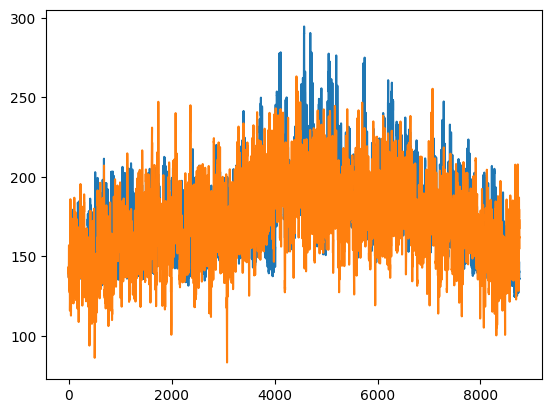

In [ ]:
# pd.Series(y.reshape(-1,)).plot()
# pd.Series(sim_out + residuals_ar.reshape(-1,)).plot()

<Axes: >

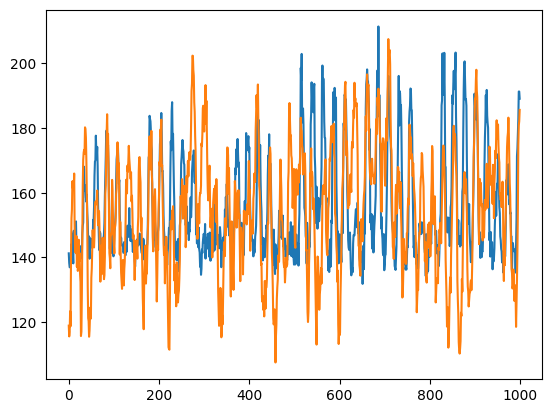

In [ ]:
# plt.plot(y[0:1000])
# pd.Series((electricity_linear_model(θ_mle, X)+ residuals_ar.reshape(-1,))[0:1000]).plot()

In [ ]:
θ_mle

array([121.2144847 ,  -0.9225982 ,  14.20521596, -14.84024673,
       151.11290647,  24.4912768 , -56.42030493,   6.20393535,
        -2.57535917,   6.05796975,   0.91809748])


references 


https://stackoverflow.com/questions/71270630/how-to-show-only-the-monthly-ticks-in-the-x-axis-when-using-dataframe-plot